In [1]:
import pandas as pd
import numpy as np 
import seaborn
import matplotlib.pyplot as plt

import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold

## Ingeneria de datos

In [2]:
MajorCityCSV = 'GlobalLandTemperaturesByMajorCity.csv'

In [3]:
# engine: para seleccionar la libreria que abre el archivo
# pyarrow para archivos muy grandes
# dtype_backend: como se almacenan los datos

MajorCityDF = pd.read_csv(
    MajorCityCSV,
    engine='pyarrow',
    dtype_backend='pyarrow'
)

In [4]:
MajorCityDF.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.14,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.2,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [5]:
MajorCityDF.describe()

,dt,AverageTemperature,AverageTemperatureUncertainty
count,239177,228175.0,228175.0
mean,1910-11-09,18.125969,0.969343
min,1743-11-01,-26.772,0.04
25%,1864-02-01,12.71,0.34
50%,1914-02-01,20.428,0.592
75%,1963-12-01,25.918,1.32
max,2013-09-01,38.283,14.037
std,NaN,10.0248,0.979644


In [6]:
MajorCityDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239177 entries, 0 to 239176
Data columns (total 7 columns):
 #   Column                         Non-Null Count   Dtype               
---  ------                         --------------   -----               
 0   dt                             239177 non-null  date32[day][pyarrow]
 1   AverageTemperature             228175 non-null  double[pyarrow]     
 2   AverageTemperatureUncertainty  228175 non-null  double[pyarrow]     
 3   City                           239177 non-null  string[pyarrow]     
 4   Country                        239177 non-null  string[pyarrow]     
 5   Latitude                       239177 non-null  string[pyarrow]     
 6   Longitude                      239177 non-null  string[pyarrow]     
dtypes: date32[day][pyarrow](1), double[pyarrow](2), string[pyarrow](4)
memory usage: 14.3 MB


El archivo MajorCityDF con 7 columnas y 239177 filas, nos entrega informacion sobre las fechas (df), temperatura promedio (AverageTemperature), incertidumbre de la temperatura promedio (AverageTemperatureUncertanity), nombre de la ciudad (City), pais (Country), latitud (Latitude) y longitud (Longitude). Revisamos a continuacion si hay datos duplicados y valores NaN en alguna de las columnas. En caso de haberlos, la fila es eliminada.

In [7]:
MajorCityDF.duplicated().sum() # buscar datos duplicados
MajorCityDF.isna().sum() # buscar valores NaN
MajorCityDF = MajorCityDF.dropna() # eliminar datos NaN

Se crean 2 columnas, 'year' y 'month', a partir de la columna 'df' que contiene la fecha en el formato dia-mes-año.

In [8]:
# se crea esta columna para obtener un valor promedio por año de las temperaturas
# columna.dt.year = extrae el año
MajorCityDF['year'] = MajorCityDF["dt"].dt.year

# Y esta otra lo mismo pero por mes
# columna.dt.month
MajorCityDF['month'] = MajorCityDF["dt"].dt.month

In [10]:
# Analizamos la cantidad de datos por cada pais
print(MajorCityDF.value_counts('Country').head(3)) # top 3 de paises con mas datos
print(MajorCityDF.value_counts('Country').tail(3)) # los 3 paises con menos datos
print(f'Total de paises: {MajorCityDF.value_counts('Country').shape[0]}')

Country
China     34952
India     34627
Brazil    12139
Name: count, dtype: int64
Country
Kenya       1678
Tanzania    1586
Peru        1521
Name: count, dtype: int64
Total de paises: 49


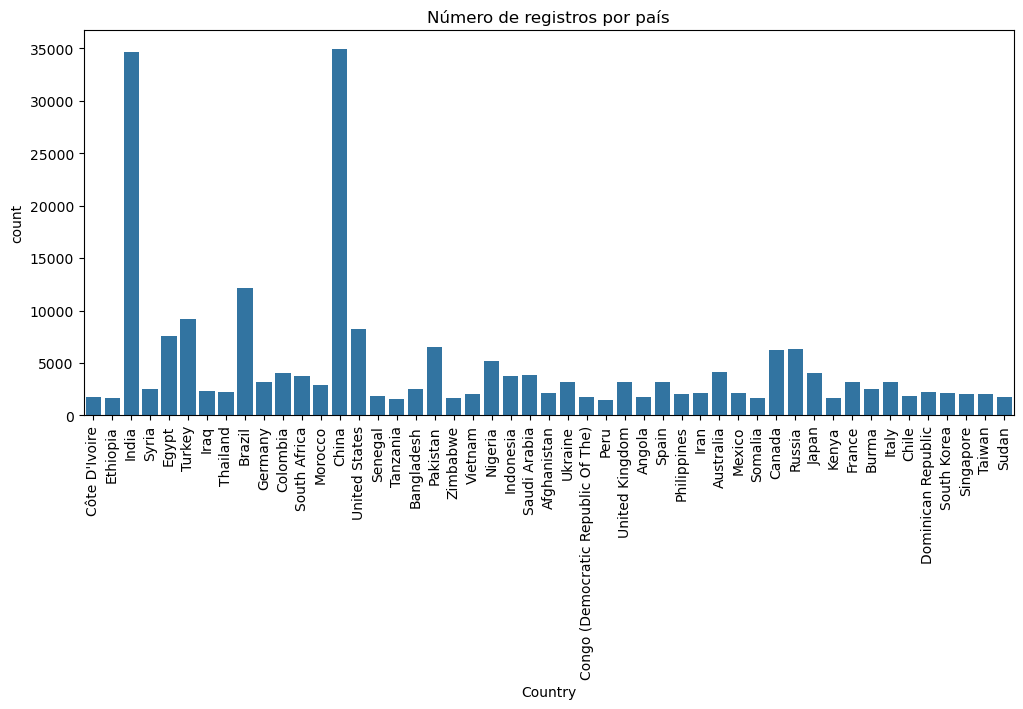

In [11]:
# Histograma para ver la contidad de datos por pais
plt.figure(figsize=(12, 5))
seaborn.countplot(data=MajorCityDF, x="Country")
plt.xticks(rotation=90)
plt.title("Número de registros por país")
plt.show()

In [12]:
# Analizamos la cantidad de datos por cada ciudad
print(MajorCityDF.value_counts('City').head(3)) # top 3 de ciudades con mas datos
print(MajorCityDF.value_counts('City').tail(3)) # las 3 ciudades con menos datos
print(f'Total de ciudades: {MajorCityDF.value_counts('City').shape[0]}')

City
Berlin    3166
Madrid    3166
Kiev      3166
Name: count, dtype: int64
City
Fortaleza        1659
Dar Es Salaam    1586
Lima             1521
Name: count, dtype: int64
Total de ciudades: 100


Los siguientes comandos se obtuvieron de ChatGPT:
- .groupby(): agrupa el dataframe con el valor de la columna
- .unique(): obtiene los valores unicos de la columna
- .items(): itera en pares (indice, valor), en este caso (pais, lista de cuidades)

In [13]:
# Numero de ciudades por pais
# las ciudades de un pais se guardan en un diccionario

cities_dicc = {country: list[cities] for country, cities in MajorCityDF.groupby("Country")["City"].unique().items()}
cities_dicc['China'] 

list[<ArrowExtensionArray>
['Changchun',   'Chengdu', 'Chongqing',    'Dalian', 'Guangzhou',    'Harbin',
     'Jinan',   'Nanjing',    'Peking',  'Shanghai',  'Shenyang',   'Taiyuan',
  'Tangshan',   'Tianjin',     'Wuhan',      'Xian']
Length: 16, dtype: string[pyarrow]]

<Axes: xlabel='year', ylabel='AverageTemperature'>

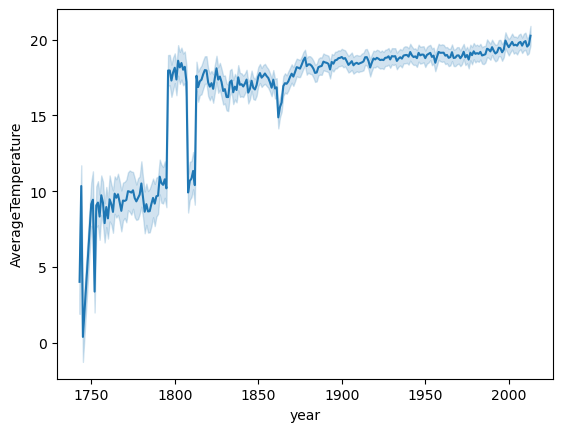

In [14]:
# Temperatura por año global (incluyendo todos los paises)
seaborn.lineplot(
    data = MajorCityDF,
    x='year',
    y='AverageTemperature',
)

In [15]:
def yr_vs_temp(country):
    """
    input: pais
    output: plot de temperatura por año para el pais
    """
    df_country = MajorCityDF[MajorCityDF['Country'] == country]

    plt.figure(figsize=(10, 5))
    plt.plot(df_country['year'], df_country['AverageTemperature'])
    plt.xlabel('Year')
    plt.ylabel('Average Temperature')
    plt.title(f"Average Temperature in {country}")
    plt.show()

def yr_vs_temp_lineplot(country):
    """
    input: pais
    output: lineplot de temperatura por año para el pais
    """
    df_country = MajorCityDF[MajorCityDF['Country'] == country]

    seaborn.lineplot(data = df_country, x='year', y='AverageTemperature')
    plt.title(f"Average Temperature in {country}")
    plt.show()

def month_vs_temp_lineplot(country):
    """
    input: pais
    output: lineplot de temperatura por mes para el pais
    """
    df_country = MajorCityDF[MajorCityDF['Country'] == country]

    seaborn.lineplot(data = df_country, x='month', y='AverageTemperature')
    plt.title(f"Average Temperature in {country}")
    plt.show()

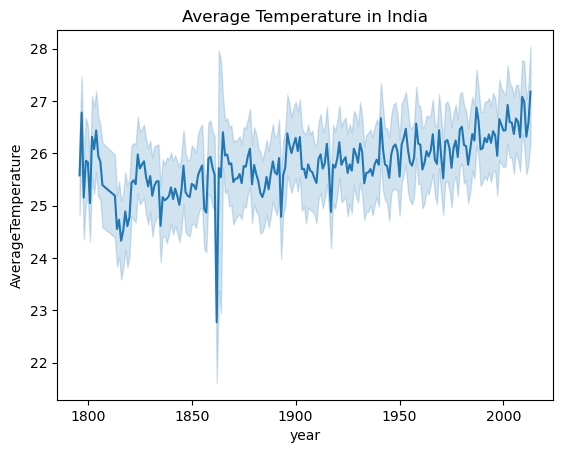

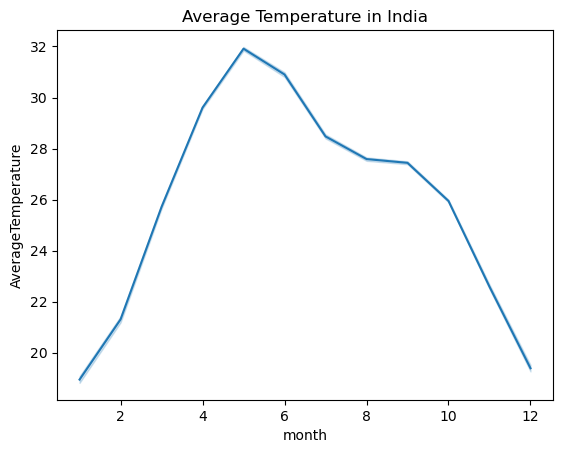

In [16]:
data_yr = yr_vs_temp_lineplot('India')
data_month = month_vs_temp_lineplot('India')

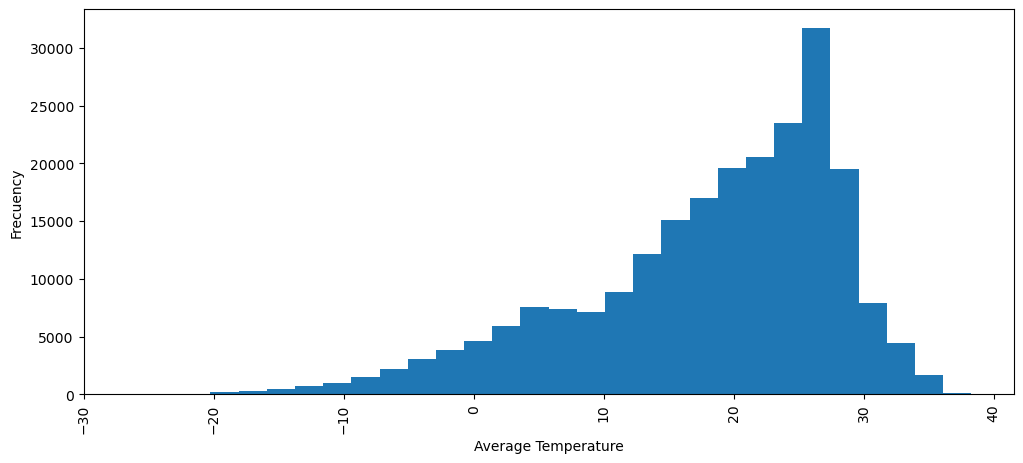

Media: 18.125968852854168
Mediana: 20.428
Desviacion estandar: 10.02479971048481


In [17]:
# Histograma para AverageTemperature
# incluye media, mediana y desviacion estandar

plt.figure(figsize=(12, 5))
plt.hist(MajorCityDF['AverageTemperature'], bins=30)
plt.xlabel("Average Temperature")
plt.ylabel("Frecuency")
plt.xticks(rotation=90)
plt.show()

print('Media:', MajorCityDF['AverageTemperature'].mean())
print('Mediana:', MajorCityDF['AverageTemperature'].median())
print('Desviacion estandar:', MajorCityDF['AverageTemperature'].std())

## Modelo de ML
Usando un modelo supervisado, se usaran los datos de temperatura promedio, latitud y longitud para predecir el pais y la ciudad. Como las etiquetas inlcuyen dos datos, se crea una nueva columna 'Label' con el formato pais-ciudad, que fucione a ambas. La temperatura promedio son variables numericas tipo, pero latitud y longitud llevan al final del numero una N, S y E, W respectivamente. Estos valores deben ser transformados a valores numericos para poder utilizarlos en el DT. El 'N' (norte) sera positivo, 'S' (sur) sera negativo, 'E' (este) sera postivo y 'W' (oeste) sera negativo.

Por lo tanto 'Country' seran las etiquetas y los valores de 'AverageTemperature' las variables. Comenzamos probando el modelo decission three, para el cual necesitamos definir un set de prueba y un set de entrenamiento. En este caso se decidio que el set de prueba seria un 20% del dataset.

In [17]:
# string: texto
# float: numero decimal

def coord_change(value):
    """
    input: valor de latitude o longitude (string)
    transforma la coordenada N,S,E,W al final del valor a +1 o -1 y lo multiplica por el valor
    output: -valor o +valor (float)
    """
    # si value es float no hace cambios
    if isinstance(value, float):
        return value

    # si value es string cambia su valor
    num = float(value[:-1]) # value sin el ultimo caracter
    coord = value[-1] # ultimo caraster de value

    if coord in ['S','W']:
        num = num*(-1)
    else:
        num = num

    return num

In [18]:
#MajorCityDF["Label"] = MajorCityDF["Country"] + " - " + MajorCityDF["City"] # columna pais-ciudad
labels = MajorCityDF["City"] # dataset con etiquetas

# transformacion de latitude y longitude
MajorCityDF['Latitude']= MajorCityDF['Latitude'].apply(coord_change)
MajorCityDF['Longitude']= MajorCityDF['Longitude'].apply(coord_change)

features = MajorCityDF[['AverageTemperature', 'Latitude', 'Longitude', 'year', 'month']] # dataset con features

In [19]:
# Dividir en set de entrenamiento y prueba
# 20% del dataset es set de entrenamiento
Xtrain, Xtest, ytrain, ytest = train_test_split(features,
                                                labels,
                                                test_size=0.2,
                                                random_state=100)

# Crear modelo de decission tree
model = DecisionTreeClassifier(random_state=100)

# Evaluar el modelo con todo el set de entrenamiento
model.fit(Xtrain, ytrain)

DecisionTreeClassifier(random_state=100)

In [20]:
# Evaluar el modelo
# valores de accuracy y recall para 1era separacion de set de entrenamiento y prueba
y_pred = model.predict(Xtest)
print("Accuracy:", metrics.accuracy_score(ytest, y_pred))

# Accuracy y recall esperan una clasificacion binaria
# como son muchos paises y ciudades, la clasificacion es multiclase
print("Recall:", metrics.recall_score(ytest, y_pred))
print('Precission:',metrics.precision_score(ytest,model.predict(Xtest)))



Accuracy: 0.9097622438917498


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].